In [1]:
import os 
import cv2
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import torchvision
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
from glob import glob

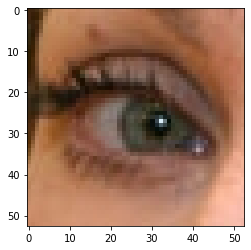

In [2]:
img = plt.imread("../input/eyes-rtte/femaleeyes/1.jpg") #Female eye
plt.imshow(img)

In [3]:
"../input/eyes-rtte/femaleeyes/1.jpg".split("/")[-2]

'femaleeyes'

In [4]:
class Eye(Dataset):
    def __init__(self,path):
        self.path = path
        self.normalize = transforms.Normalize(mean = [0.485,0.456,0.406],std = [0.229,0.224,0.225])
    def __len__(self):
        return len(self.path)
    def __getitem__(self,ix):
        img = cv2.imread(self.path[ix])[:,:,::-1]
        img = cv2.resize(img,(224,224))
        img = torch.tensor(img/255.).permute(2,0,1)
        img = self.normalize(img).to(device)
        target = self.path[ix].split("/")[-2]
        if target == "femaleeyes":
            target = 0
        else:
            target = 1
        target = torch.tensor(int(target)).long()
        return img.float(),target.to(device)
    
        
        
        
        

In [5]:
path = glob("../input/eyes-rtte/femaleeyes/*") + glob("../input/eyes-rtte/maleeyes/*")

In [6]:
from random import shuffle
from random import seed
seed(42)
shuffle(path)
path[:15]

['../input/eyes-rtte/femaleeyes/2557.jpg',
 '../input/eyes-rtte/maleeyes/6046.jpg',
 '../input/eyes-rtte/maleeyes/1635.jpg',
 '../input/eyes-rtte/femaleeyes/5426.jpg',
 '../input/eyes-rtte/femaleeyes/3715.jpg',
 '../input/eyes-rtte/maleeyes/6535.jpg',
 '../input/eyes-rtte/femaleeyes/2888.jpg',
 '../input/eyes-rtte/femaleeyes/4730.jpg',
 '../input/eyes-rtte/maleeyes/639.jpg',
 '../input/eyes-rtte/maleeyes/3404.jpg',
 '../input/eyes-rtte/maleeyes/5216.jpg',
 '../input/eyes-rtte/maleeyes/3689.jpg',
 '../input/eyes-rtte/femaleeyes/2616.jpg',
 '../input/eyes-rtte/maleeyes/5619.jpg',
 '../input/eyes-rtte/maleeyes/4997.jpg']

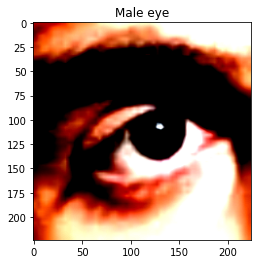

In [22]:
train = Eye(path)
im,target = train[2]
plt.imshow(im.permute(1,2,0).cpu().numpy())
plt.title("Male eye")
plt.show()

In [8]:
train_loader = DataLoader(train,batch_size = 32,shuffle = True)

In [9]:
model = models.vgg16(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.avgpool = nn.AdaptiveAvgPool2d(output_size = (1,1))

model.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(512,128),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(128,29),
               
)
    

In [10]:

loss_fn = torch.nn.CrossEntropyLoss()

# all parameters are being optimized
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [11]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
model = model.to(device)

In [13]:
losses = []
correct = 0
total = 0
for i in range(5):
    train_loss = 0
    model.train()
    for ix,data in enumerate(train_loader):
        im,target = data
        optimizer.zero_grad()
        prediction = model(im)
        loss = loss_fn(prediction,target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(data)
        _,predicted = torch.max(prediction.data,1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
    train_loss = train_loss / len(train_loader.sampler)
    losses.append(train_loss)
    
    print(f"Epochs: {i+1} / 5 , Training Loss : {train_loss} , Training Accuracy : {100*(correct / total)}")
        
        

Epochs: 1 / 5 , Training Loss : 0.053085647182712845 , Training Accuracy : 63.24511930585683
Epochs: 2 / 5 , Training Loss : 0.03026708448269362 , Training Accuracy : 70.68546637744035
Epochs: 3 / 5 , Training Loss : 0.02534919682138654 , Training Accuracy : 74.6001446131598
Epochs: 4 / 5 , Training Loss : 0.023343956648915552 , Training Accuracy : 76.96312364425162
Epochs: 5 / 5 , Training Loss : 0.021896593159553543 , Training Accuracy : 78.61518438177875


In [14]:
predicted_labels = []
img = cv2.imread("../input/eyes-rtte/maleeyes/0.jpg")[:,:,::-1]
img = cv2.resize(img,(224,224))
img = torch.tensor(img/255.).permute(2,0,1)
img = train.normalize(img)
img = img.to(device)
logit = model(img[None].float())
preds = torch.max(logit, 1)[1]
#logit = torch.round(logit)
#logit


In [15]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [16]:
final_layer = model._modules.get("features")[28]

In [17]:
final_layer

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [18]:
activated_features = SaveFeatures(final_layer)

In [23]:
from torch.autograd import Variable
prediction_var = Variable((im.unsqueeze(0)).cuda(), requires_grad=True)

In [24]:
prediction_var.shape

torch.Size([1, 3, 224, 224])

In [25]:
prediction = model(prediction_var)
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [26]:
from torch import topk
topk(pred_probabilities,1)

torch.return_types.topk(
values=tensor([0.6203], device='cuda:0'),
indices=tensor([1], device='cuda:0'))

In [27]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [28]:
weight_softmax_params = list(model._modules.get('classifier').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [29]:
weight_softmax_params

[Parameter containing:
 tensor([[ 0.0184, -0.0410,  0.0558,  ...,  0.0400, -0.0427,  0.0412],
         [-0.0184, -0.0227, -0.0153,  ...,  0.0067, -0.0264,  0.0294],
         [ 0.0337,  0.0028,  0.0586,  ..., -0.0059, -0.0036, -0.0065],
         ...,
         [ 0.0221,  0.0173, -0.0057,  ...,  0.0128,  0.0113, -0.0308],
         [-0.0059,  0.0249,  0.0347,  ...,  0.0240, -0.0320,  0.0079],
         [-0.0336, -0.0076,  0.0182,  ...,  0.0227, -0.0192, -0.0389]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-3.8036e-03,  9.1778e-03,  6.7446e-02,  2.3055e-02,  1.6638e-02,
         -5.1028e-03, -9.9942e-03,  7.5968e-02, -2.4503e-02, -3.9274e-02,
          8.1061e-03, -8.4727e-05,  3.6401e-02, -1.7812e-02, -3.5203e-02,
          1.6465e-02, -2.7726e-02,  3.5940e-02,  4.3482e-03,  3.9064e-02,
         -2.3990e-02, -3.6711e-02, -1.7052e-02, -8.3256e-03,  1.0079e-02,
          5.2027e-02,  1.2649e-02, -1.4354e-02,  4.2349e-02,  1.6250e-02,
          4.0363e-02,  

In [30]:
class_idx = topk(pred_probabilities,1)[1].int()

In [31]:
class_idx

tensor([1], device='cuda:0', dtype=torch.int32)

In [32]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx )

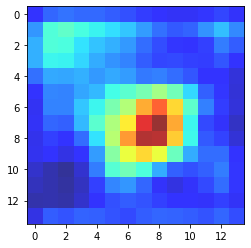

In [33]:
plt.imshow(overlay[0],alpha=0.8, cmap="jet")

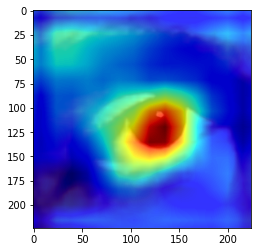

In [34]:
import skimage.transform
plt.imshow(im.permute(1,2,0).cpu().numpy())
plt.imshow(skimage.transform.resize(overlay[0], (224,224)), alpha=0.8, cmap='jet');